In [ ]:
%%time
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import pandas as pd

from google.colab import drive
drive.mount('/content/gdrive')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    ls = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            # add to list which gets returned
            ls.append((
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
            if args.dry_run:
                return(ls)
                break
    return ls

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return [(test_loss, correct, len(test_loader.dataset),
             100. * correct / len(test_loader.dataset))]


def main():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=14, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--no-mps', action='store_true', default=False,
                        help='disables macOS GPU training')
    parser.add_argument('--dry-run', action='store_true', default=False,
                        help='quickly check a single pass')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    parser.add_argument('-f')
    args = parser.parse_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()
    use_mps = not args.no_mps and torch.backends.mps.is_available()

    torch.manual_seed(args.seed)

    if use_cuda:
        device = torch.device("cuda")
    elif use_mps:
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    dataset1 = datasets.MNIST('../data', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.MNIST('../data', train=False,
                       transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    train_ls = []
    test_ls = []
    for epoch in range(1, args.epochs + 1):
        curr_tr_ls = train(args, model, device, train_loader, optimizer, epoch)
        train_ls.extend(curr_tr_ls)
        curr_te_ls = test(model, device, test_loader)
        test_ls.extend(curr_te_ls)

        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")

    base_outpth = '/content/gdrive/My Drive/colab_notebooks/data/'
    tr_outpth = os.path.join(base_outpth, 'train_stats.csv')
    te_outpth = os.path.join(base_outpth, 'test_stats.csv')

    train_stats = pd.DataFrame(train_ls, columns=['epoch', 'train_example_num', 'num_examples', 'percentage_of_examples', 'loss'])
    test_stats = pd.DataFrame(test_ls, columns=['average_loss', 'num_correct', 'test_size', 'accuracy'])
    
    train_stats.to_csv(tr_outpth, index=False)
    test_stats.to_csv(te_outpth, index=False)

    return train_stats, test_stats

if __name__ == '__main__':
    train_stats, test_stats = main()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.299824
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.771508
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.950519
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.658959
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.303416
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.323190
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.152533
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.531138
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.269302
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.146324
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.285488
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.317067
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.419974
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.161970
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.217496
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.103642
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.184252
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.36570

In [ ]:
test_stats.tail()

,average_loss,num_correct,test_size,accuracy
9,0.027705,9915,10000,99.15
10,0.027111,9920,10000,99.20
11,0.027103,9916,10000,99.16
12,0.027714,9914,10000,99.14
13,0.027283,9917,10000,99.17


In [ ]:
!pip install opacus
# !pip install torchvision
# !pip install torch==1.8.0
# !pip install torchvision==0.9.0
# !pip install torchaudio==0.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached torch-1.13.0-cp37-cp37m-manylinux1_x86_64.whl (890.2 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.8.0
    Uninstalling torch-1.8.0:
      Successfully uninstalled torch-1.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.9.0 requires torch==1.8.0, but you have torch 1.13.0 which is incompatible.
torchtext 0.13.1 requires torch==1.12.1, but you have torch 1.13.0 which is incompatible.
torchaudio 0.8.0 requires torch==1.8.0, but you have torch 1.13.0 which is incompatible.


In [ ]:
%%time
from __future__ import print_function
from pandas.core.base import NoNewAttributesMixin
from opacus import PrivacyEngine
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import pandas as pd
import os

from google.colab import drive
drive.mount('/content/gdrive')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
        
        # self.privacy_engine = PrivacyEngine()
        # self.epilon = None
        # self.delta = None
        

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


def train(args, model, device, train_loader, optimizer, epoch, privacy_map):
    model.train()
    ls = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            curr_privacy = round(privacy_map['privacy_engine'].get_epsilon(privacy_map['target_delta']), 3)
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Privacy loss: {}, {}/{}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(),
                curr_privacy, 
                privacy_map['target_delta'], privacy_map['target_epsilon']))
            # add to list which gets returned
            ls.append((
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(),
                curr_privacy))
            
            if args.dry_run:
                return(ls)
                break
    return ls

def test(model, device, test_loader, privacy_map):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    curr_privacy = round(privacy_map['privacy_engine'].get_epsilon(privacy_map['target_delta']), 3)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), Privacy: {},{}/{}\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset),
        curr_privacy, 
        privacy_map['target_delta'], privacy_map['target_epsilon']))
    return [(test_loss, correct, len(test_loader.dataset),
             100. * correct / len(test_loader.dataset), curr_privacy)]

def main():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=14, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--no-mps', action='store_true', default=False,
                        help='disables macOS GPU training')
    parser.add_argument('--dry-run', action='store_true', default=False,
                        help='quickly check a single pass')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    parser.add_argument('-f')
    args = parser.parse_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()
    use_mps = not args.no_mps and torch.backends.mps.is_available()

    torch.manual_seed(args.seed)

    if use_cuda:
        device = torch.device("cuda")
    elif use_mps:
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    dataset1 = datasets.MNIST('../data', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.MNIST('../data', train=False,
                       transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    # Privacy budget - uses settings from this:
    # https://github.com/pytorch/opacus/blob/main/tutorials/building_image_classifier.ipynb

    MAX_GRAD_NORM = 1.2
    EPSILON = 3
    DELTA = 1e-5
    EPOCHS = args.epochs

    LR = 1e-3

    privacy_engine = PrivacyEngine()

    model, optimizer, data_loader = privacy_engine.make_private_with_epsilon(
                                                    module=model,
                                                    optimizer=optimizer,
                                                    data_loader=train_loader,
                                                    epochs=EPOCHS,
                                                    target_epsilon=EPSILON,
                                                    target_delta=DELTA,
                                                    max_grad_norm=MAX_GRAD_NORM)
    
    # model.epsilon = EPSILON
    # model.delta = DELTA

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    train_ls = []
    test_ls = []
    for epoch in range(1, args.epochs + 1):
        curr_tr_ls = train(args, model, device, train_loader, optimizer, epoch,
                           {'privacy_engine': privacy_engine,
                           'target_epsilon':EPSILON,
                           'target_delta': DELTA})
        train_ls.extend(curr_tr_ls)
        curr_te_ls = test(model, device, test_loader, 
                          {'privacy_engine': privacy_engine,
                           'target_epsilon':EPSILON,
                           'target_delta': DELTA})
        test_ls.extend(curr_te_ls)

        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")

    base_outpth = '/content/gdrive/My Drive/colab_notebooks/data/'
    tr_outpth = os.path.join(base_outpth, 'p_train_stats.csv')
    te_outpth = os.path.join(base_outpth, 'p_test_stats.csv')

    train_stats = pd.DataFrame(train_ls, columns=['epoch', 'train_example_num', 'num_examples', 'percentage_of_examples', 'loss', 'curr_privacy'])
    test_stats = pd.DataFrame(test_ls, columns=['average_loss', 'num_correct', 'test_size', 'accuracy', 'curr_privacy'])
    
    train_stats.to_csv(tr_outpth, index=False)
    test_stats.to_csv(te_outpth, index=False)

    return train_stats, test_stats

if __name__ == '__main__':
    p_train_stats, p_test_stats = main()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.299824, Privacy loss: 1.681, 1e-05/3
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.250466, Privacy loss: 1.811, 1e-05/3
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.103608, Privacy loss: 1.851, 1e-05/3
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.780792, Privacy loss: 1.875, 1e-05/3
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.566189, Privacy loss: 1.896, 1e-05/3
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.654005, Privacy loss: 1.91, 1e-05/3
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.131251, Privacy loss: 1.923, 1e-05/3
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.559924, Privacy loss: 1.936, 1e-05/3
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.270841, Privacy loss: 1.947, 1e-05/3
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.419631, Privacy loss: 1.954, 1e-05/3
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.306369, Privacy loss: 1.961, 1e-05/3
Train Epoch: 1

In [ ]:

!ls -l '/content/gdrive/My Drive/colab_notebooks/data/'

total 137
-rw------- 1 root root    42 Oct 16 04:31 first_file.csv
-rw------- 1 root root   543 Oct 16 04:59 p_test_stats.csv
-rw------- 1 root root 67255 Oct 16 04:59 p_train_stats.csv
-rw------- 1 root root   568 Oct 16 04:41 test_stats.csv
-rw------- 1 root root 69634 Oct 16 04:41 train_stats.csv


In [ ]:
train_stats.tail(), p_train_stats.tail()

(      epoch  train_example_num  num_examples  percentage_of_examples      loss
 1311     14              56960         60000               94.882729  0.068968
 1312     14              57600         60000               95.948827  0.001255
 1313     14              58240         60000               97.014925  0.011428
 1314     14              58880         60000               98.081023  0.004694
 1315     14              59520         60000               99.147122  0.003094,
       epoch  train_example_num  num_examples  percentage_of_examples      loss
 1311     14              56960         60000               94.882729  0.915253
 1312     14              57600         60000               95.948827  0.862054
 1313     14              58240         60000               97.014925  2.390769
 1314     14              58880         60000               98.081023  0.797129
 1315     14              59520         60000               99.147122  1.240519)

In [ ]:
test_stats.tail(), p_test_stats.tail()

(    average_loss  num_correct  test_size  accuracy
 9       0.027705         9915      10000     99.15
 10      0.027111         9920      10000     99.20
 11      0.027103         9916      10000     99.16
 12      0.027714         9914      10000     99.14
 13      0.027283         9917      10000     99.17,
     average_loss  num_correct  test_size  accuracy
 9       0.403490         9225      10000     92.25
 10      0.399987         9235      10000     92.35
 11      0.396432         9226      10000     92.26
 12      0.396736         9236      10000     92.36
 13      0.396802         9239      10000     92.39)

In [ ]:
train_stats.tail(), p_train_stats.tail()

(      epoch  train_example_num  num_examples  percentage_of_examples      loss
 1311     14              56960         60000               94.882729  0.068968
 1312     14              57600         60000               95.948827  0.001255
 1313     14              58240         60000               97.014925  0.011428
 1314     14              58880         60000               98.081023  0.004694
 1315     14              59520         60000               99.147122  0.003094,
       epoch  train_example_num  num_examples  percentage_of_examples      loss
 1311     14              56960         60000               94.882729  0.915253
 1312     14              57600         60000               95.948827  0.862054
 1313     14              58240         60000               97.014925  2.390769
 1314     14              58880         60000               98.081023  0.797129
 1315     14              59520         60000               99.147122  1.240519)

In [ ]:
!ls -l gdrive/MyDrive/colab_notebooks/data

total 145
-rw------- 1 root root    42 Oct 16 04:31 first_file.csv
-rw------- 1 root root   641 Nov  5 21:46 p_test_stats.csv
-rw------- 1 root root 75030 Nov  5 21:46 p_train_stats.csv
-rw------- 1 root root   563 Nov  5 20:40 test_stats.csv
-rw------- 1 root root 69657 Nov  5 20:40 train_stats.csv


In [ ]:

base = '/content/gdrive/MyDrive/colab_notebooks/data'

train_df = pd.read_csv(os.path.join(base, 'train_stats.csv'))
test_df = pd.read_csv(os.path.join(base, 'test_stats.csv'))

p_train_df = pd.read_csv(os.path.join(base, 'p_train_stats.csv'))
p_test_df = pd.read_csv(os.path.join(base, 'p_test_stats.csv'))

In [ ]:

train_df.head()

,epoch,train_example_num,num_examples,percentage_of_examples,loss
0,1,0,60000,0.000000,2.299824
1,1,640,60000,1.066098,1.771508
2,1,1280,60000,2.132196,0.950519
3,1,1920,60000,3.198294,0.658959
4,1,2560,60000,4.264392,0.303416


In [ ]:

p_train_df.head()

,epoch,train_example_num,num_examples,percentage_of_examples,loss,curr_privacy
0,1,0,60000,0.000000,2.299824,1.681
1,1,640,60000,1.066098,2.250466,1.811
2,1,1280,60000,2.132196,2.103608,1.851
3,1,1920,60000,3.198294,1.780792,1.875
4,1,2560,60000,4.264392,1.566189,1.896


In [ ]:
p_test_df.head()

,average_loss,num_correct,test_size,accuracy,curr_privacy
0,0.537703,8721,10000,87.21,2.200
1,0.489345,8961,10000,89.61,2.314
2,0.489763,8998,10000,89.98,2.403
3,0.446895,9121,10000,91.21,2.473
4,0.418516,9154,10000,91.54,2.542


Text(0.5, 1.0, 'MNIST test accuracy - accuracy vs privacy')

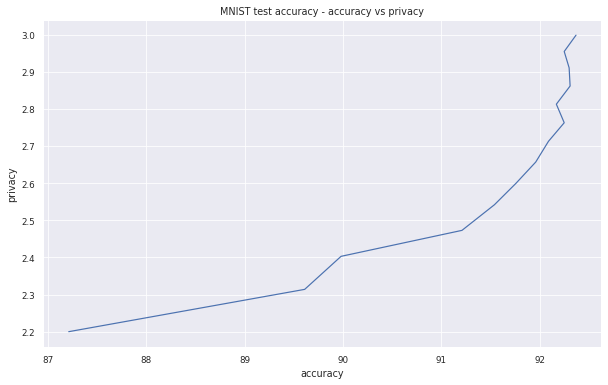

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]
import seaborn as sns
sns.set_theme()
sns.set_context("paper")
plt.style.context('seaborn-poster')
import numpy as np

# Privacy budget epsilon = 3 ==> full 10% lower --> 7% lower
plt.plot(p_test_df['accuracy'], p_test_df['curr_privacy'])
# plt.plot(p_train_df.index.values, p_train_df['curr_privacy'])
plt.xlabel('accuracy')
plt.ylabel('privacy')
plt.title('MNIST test accuracy - accuracy vs privacy')


Text(0.5, 1.0, 'MNIST test accuracy/privacy by epoch')

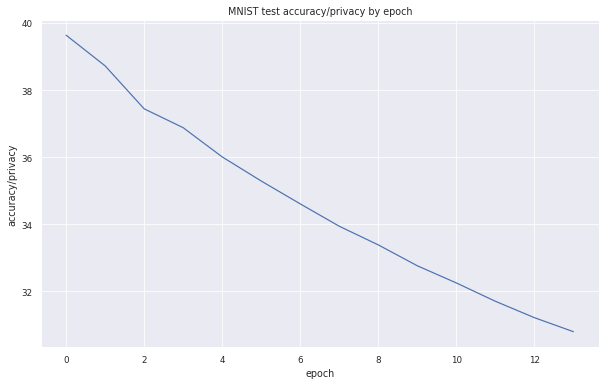

In [ ]:
# Privacy budget epsilon = 3 ==> full 10% lower --> 7% lower
plt.plot(p_test_df.index.values, p_test_df['accuracy']/p_test_df['curr_privacy'])
# plt.plot(p_train_df.index.values, p_train_df['curr_privacy'])
plt.xlabel('epoch')
plt.ylabel('accuracy/privacy')
plt.title('MNIST test accuracy/privacy by epoch')


Text(0.5, 1.0, 'MNIST test accuracy/privacy by epoch')

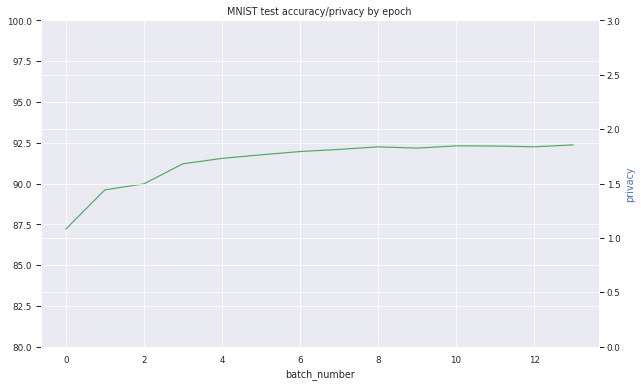

In [ ]:

# Privacy budget epsilon = 3 ==> full 10% lower --> 7% lower

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(p_test_df.index.values, p_test_df['accuracy'], 'g-',label='accuracy')
ax1.plot(p_test_df.index.values, p_test_df['curr_privacy'], 'b', label='accuracy & privacy')
ax1.set_xlabel('batch_number')
# plt.ylabel(label='accuracy & privacy')
ax2.set_ylabel('accuracy', color='g')
ax2.set_ylabel('privacy', color='b')
ax1.set_ylim([80, 100])
ax2.set_ylim([0,3])
plt.title('MNIST test accuracy/privacy by epoch')
# plt.legend()

In [ ]:

p_test_df['curr_privacy']

0     2.200
1     2.314
2     2.403
3     2.473
4     2.542
5     2.600
6     2.657
7     2.713
8     2.763
9     2.813
10    2.862
11    2.911
12    2.955
13    2.999
Name: curr_privacy, dtype: float64

In [ ]:

# Privacy budget epsilon = 3 ==> full 10% lower --> 7% lower
plt.plot(p_test_df['loss'], p_test_df['curr_privacy'])
# plt.plot(p_train_df.index.values, p_train_df['curr_privacy'])
plt.xlabel('loss')
plt.ylabel('privacy')
plt.title('MNIST test accuracy - non-DP vs DP')

Privacy budget of epsilon = 3, delta = 10^-5 --> performance loss of 7-10%, with a similar run-time (2 mins for 60000 samples - 50k train, 10k test, 14 epochs)

Text(0.5, 1.0, 'MNIST test accuracy - non-DP vs DP')

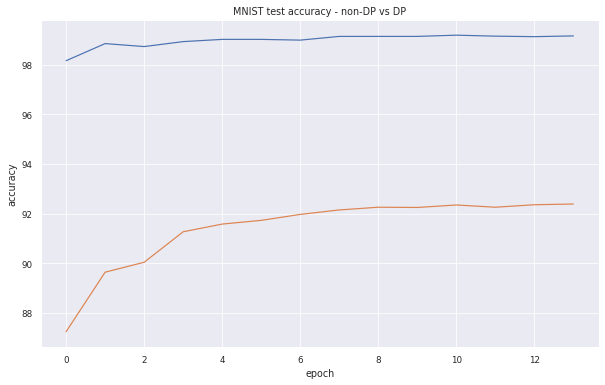

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]
import seaborn as sns
sns.set_theme()
sns.set_context("paper")
plt.style.context('seaborn-poster')

# Privacy budget epsilon = 3 ==> full 10% lower --> 7% lower
plt.plot(test_stats.index.values, test_stats['accuracy'])
plt.plot(p_test_stats.index.values, p_test_stats['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('MNIST test accuracy - non-DP vs DP')



In [ ]:
import os
from google.colab import drive
import pandas as pd
drive.mount('/content/gdrive')


base = '/content/gdrive/My Drive/Colab Notebooks/data/' 
outpth = os.path.join(base, 'first_file.csv')

df = pd.DataFrame([('rohun', 'dad'), ('diana', 'mom'), ('sadie', 'baby')], columns=['name', 'title'])
df.to_csv(outpth, index=False)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Test class
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import pandas as pd

class RoNet(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
